##  Modeling the Impact of Lateral Flow Parameterizations on Total Evapotranspiration in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

One part of the Clark et al. (2015) study explored the impact of the lateral flux of liquid water on total evapotranspiration (ET) using a SUMMA model for the Reynolds Mountain East catchment. This study looked at the sensitivity of the different model representation of the lateral flux of liquid water, which determines the availability of soil water.

In this Jupyter Notebook, the pySUMMA library is used to reproduce this analysis. First, the latertal flux from the soil profile are described. Next, the Methods section describes how the pySUMMA can be used to create three different lateral model representation of the Reynolds Mountain East catchment model, 1d Richards', lumped topmodel, and distributed topmodel. The Results section shows how to use pySUMMA and the Pandas library to reproduce Figure 8(right) from Clark et al. (2015).

Collectively, this Jupyter Notebook serves as an example of how hydrologic modeling can be conducted directly within a Jupyter Notebook by leveraging the pySUMMA library. 

 |                    Method                   | 1dRichards' |   Lumped Topmodel |   Distributed Topmodel |
 |---------------------------------------------|-------------|-------------------|------------------------|
 |         groundwater parameterization        | noXplict    | qTopmodl          | qTopmodl               |
 |       hydraulic conductivity profile        | constant    | pow_prof          | pow_prof               |
 |lower boundary condition for soil hydrology  | drainage    | zeroFlux          | zeroFlux               |
 |thermal conductivity representation for soil | mixConstit  | funcSoilWet       | funcSoilWet            |

## 2. Background

### Latertal flux from the soil profile

The soil columns can be hydrologically connected, such that the lateral flux from upslope soil columns is the inflow to downslope soil columns, or hydrologically-disconnected (using one or many soil columns), in which case the lateral flux of water from soil columns is assumed to flow directly into the river network.

The continuity equation for sub-surface storage (i.e., below the water table) can be written for a given model element as [Wigmosta et al., 1994]

\begin{equation*}
Q_{dr} = \frac{dz_{wt}}{dt} = \frac{Q_{out}-Q_{in}}{A} - q_{rchg}
\end{equation*}

$Q_{dr} = (\theta_{sat}^{soil} - \theta_{fc}^{soil}) $ : “drainable” porosity, $\theta_{fc}^{soil}$ : the field capacity of soil, $z_{wt}$ $(m)$ : the depth to the water table

$Q_{out}$ and $Q_{in}$ $(m^{3}/s)$: the lateral inflow and outflow, $q_{rchg}$ $(m/s)$ : the vertical recharge rate, $A$ $(m^2)$ : the element area

#### Storage-based implementation to represent lateral flow between soil columns

The “drainable” water storage and the maximum drainable water storage can be given as
\begin{equation*}
W_{dr}^{soil} = \int_{z_{crit}}^{z_{soil}}\ [\theta_{liq}^{soil} (z) - \theta_{fc}^{soil} ] \mathrm{d}z, \          W_{dr,max}^{soil} = \phi_{dr}z_{soil}
\end{equation*}

$\theta_{liq}^{soil} (z)$ : the volumetric liquid water content at soil depth z, $z_{crit}$ : the lowest point in the soil profile where $\theta_{liq}^{soil}$ < $\theta_{fc}^{soil}$

#### The total lateral outflow

\begin{equation*}
Q_{out} = x_{len}tan(\beta) \frac{K_{sat}^{0} W_{dr,max}^{soil}}{\phi_{dr}n_{sf}}[\frac{W_{dr}^{soil}}{W_{dr,max}^{soil}}]^{n_{sf}}
\end{equation*}

$\beta$ : the gradient in the land surface, used to approximate the water table gradient

#### The total lateral flux

\begin{equation*}
q_{base}^{soil} =  \frac{Q_{out}-Q_{in}}{A}
\end{equation*}

The total lateral flux $q_{base}^{soil}$ can then be apportioned to individual soil layers, obtained after spatial discretization described in Clark et al. [2015b], to provide the lateral flow sink term

\begin{equation*}
(S_{lf})_{j} = (w_{tv})_{j}   q_{base}^{soil}
\end{equation*}

$(w_{tv})_{j}$ : the ratio of the transmissivity of the $j$-th layer to the total transmissivity

The above descriptions are taken from the lateral flux from the soil profile section(3.2.3.5) within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Install pySUMMA from GitHub (UVA-Hydroinformatics/pysumma-develop branch)

In [ ]:
# On HydroShare, pySUMMA installed, so users don't need to install pySUMMA.
# !/opt/conda/bin/pip install git+https://github.com/uva-hydroinformatics/pysumma.git@develop

### 2) Download SUMMA Model Instance from HydroShare

In [1]:
from pysumma.utils import utils

In [2]:
# Download SUMMA Model Instance from HydroShare
resource_id = '11d471b6096d4eaa81068256d281a919'
instance = utils.download_model_instance(resource_id)

### 3) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

In [3]:
from ipyleaflet import Map, GeoJSON
import json, os

In [4]:
m = Map(center=[43.06745, -116.75489], zoom=15)
with open(os.getcwd() + '/' + instance + '/data/reynolds_geojson_latlon.geojson') as f:
    data = json.load(f)
g = GeoJSON(data=data)
m.add_layer(g)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### 4) Create pySUMMA Simulation Object of 1d Richards method and Run SUMMA Model

In [5]:
from pysumma.Simulation import Simulation

In [6]:
# path to the SUMMA filemanager file
file_manager = os.getcwd() + '/' + instance + '/settings/summa_fileManager_1dRichards.txt'

In [7]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_1dRichards = Simulation(file_manager)

ModelOuput master file filepath: /home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/meta/var_lookup.f90


In [8]:
# check the simulation start and finish times
S_1dRichards.decision_obj.simulStart.value, S_1dRichards.decision_obj.simulFinsh.value

('2002-07-01 00:00', '2008-09-30 00:00')

In [9]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_1dRichards.decision_obj.groundwatr.options, S_1dRichards.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'noXplict')

In [10]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_1dRichards.decision_obj.hc_profile.options, S_1dRichards.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'constant')

In [11]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_1dRichards.decision_obj.bcLowrSoiH.options, S_1dRichards.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'drainage')

In [12]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_1dRichards.decision_obj.thCondSoil.options, S_1dRichards.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'mixConstit')

In [13]:
# check Basin variable meta data in file manager file
S_1dRichards.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [14]:
# check Basin Parameter info data in file manager file
S_1dRichards.basin_par.filename

'summa_zBasinParamInfo.txt'

In [15]:
# check Forcing list data in file manager file
S_1dRichards.forcing_list.filename

'summa_zForcingFileList_riparianAspen_1dRichards.txt'

In [16]:
# check Initial condition data in file manager file
S_1dRichards.initial_cond.filename

'summa_zInitialCond.nc'

In [17]:
S_1dRichards.output_prefix.value = "1dRichards"

#### if you executed SUMMA for this test case previously and have output file in output folder, you can move to next line.

In [49]:
# run the model giving the output the suffix "1dRichards_docker_develop" and get "results_1dRichards" object
S_1dRichards.executable = "/code/bin/summa.exe"
results_1dRichards, output_R = S_1dRichards.execute(run_suffix="1dRichards", run_option = 'local')

Job finished                                           
task complete
file_master is '/tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/summa_fileManager_1dRichards.txt_tmp'.
start at 00:00:58
Name of Model Output control file: /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/meta/Model_Output.txt
decisions file =  /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/summa_zDecisions_1dRichards.txt
   1 simulStart: 2002-07-01 00:00
   2 simulFinsh: 2008-09-30 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBerry
   7 num_method: itertive
   8 fDerivMeth: analy

In [50]:
# get xarry output and output path if you executed SUMMA.
S_1dRichards.output_prefix.value = "1dRichards"
results_1dRichards, output_R = S_1dRichards.get_output("cuahsi_sopron", S_1dRichards.output_prefix.value)

### 4) Create pySUMMA Simulation Object of Lumped Topmodel method and Run SUMMA Model

In [51]:
# path to the SUMMA filemanager file
file_manager = os.getcwd() + '/' + instance + '/settings/summa_fileManager_lumpedTopmodel.txt'

In [52]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_lumpedTopmodel = Simulation(file_manager)

ModelOuput master file filepath: /home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/meta/var_lookup.f90


In [53]:
# check the simulation start and finish times
S_lumpedTopmodel.decision_obj.simulStart.value, S_lumpedTopmodel.decision_obj.simulFinsh.value

('2001-07-01 00:00', '2008-09-30 00:00')

In [54]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_lumpedTopmodel.decision_obj.groundwatr.options, S_lumpedTopmodel.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'qTopmodl')

In [55]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_lumpedTopmodel.decision_obj.hc_profile.options, S_lumpedTopmodel.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'pow_prof')

In [56]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_lumpedTopmodel.decision_obj.bcLowrSoiH.options, S_lumpedTopmodel.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'zeroFlux')

In [57]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_lumpedTopmodel.decision_obj.thCondSoil.options, S_lumpedTopmodel.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'funcSoilWet')

In [58]:
# check Basin variable meta data in file manager file
S_lumpedTopmodel.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [59]:
# check Basin Parameter info data in file manager file
S_lumpedTopmodel.basin_par.filename

'summa_zBasinParamInfo.txt'

In [60]:
# check Forcing list data in file manager file
S_lumpedTopmodel.forcing_list.filename

'summa_zForcingFileList_riparianAspen_lumpedTopmodel.txt'

In [61]:
# check Initial condition data in file manager file
S_lumpedTopmodel.initial_cond.filename

'summa_zInitialCond.nc'

In [62]:
S_lumpedTopmodel.output_prefix.value = "lumpedTopmodel"

#### if you executed SUMMA for this test case previously and have output file in output folder, you can move to next line.

In [63]:
# run the model giving the output the suffix "lumpedTopmodel_docker_develop" and get "results_lumpedTopmodel" object
S_lumpedTopmodel.executable = "/code/bin/summa.exe"
results_lumpedTopmodel, output_LT = S_lumpedTopmodel.execute(run_suffix="lumpedTopmodel", run_option = 'local')

Job finished                                           
task complete
file_master is '/tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/summa_fileManager_lumpedTopmodel.txt_tmp'.
start at 00:03:03
Name of Model Output control file: /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/meta/Model_Output.txt
decisions file =  /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/summa_zDecisions_lumpedTopmodel.txt
   1 simulStart: 2001-07-01 00:00
   2 simulFinsh: 2008-09-30 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBerry
   7 num_method: itertive
   8 fDerivMet

In [64]:
# get xarry output and output path if you executed SUMMA.
S_lumpedTopmodel.output_prefix.value = "lumpedTopmodel"
results_lumpedTopmodel, output_LT = S_lumpedTopmodel.get_output("cuahsi_sopron", S_lumpedTopmodel.output_prefix.value)

### 5) Create pySUMMA Simulation Object of Distributed Topmodel method and Run SUMMA Model

In [65]:
# path to the SUMMA filemanager file
file_manager = os.getcwd() + '/' + instance + '/settings/summa_fileManager_distributedTopmodel.txt'

In [66]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_distributedTopmodel = Simulation(file_manager)

ModelOuput master file filepath: /home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/meta/var_lookup.f90


In [67]:
# check the simulation start and finish times
S_distributedTopmodel.decision_obj.simulStart.value, S_distributedTopmodel.decision_obj.simulFinsh.value

('2001-07-01 00:00', '2008-09-30 00:00')

In [68]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_distributedTopmodel.decision_obj.groundwatr.options, S_distributedTopmodel.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'qTopmodl')

In [69]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_distributedTopmodel.decision_obj.hc_profile.options, S_distributedTopmodel.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'pow_prof')

In [70]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_distributedTopmodel.decision_obj.bcLowrSoiH.options, S_distributedTopmodel.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'zeroFlux')

In [71]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_distributedTopmodel.decision_obj.thCondSoil.options, S_distributedTopmodel.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'funcSoilWet')

In [72]:
# check Basin variable meta data in file manager file
S_distributedTopmodel.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [73]:
# check Basin Parameter info data in file manager file
S_distributedTopmodel.basin_par.filename

'summa_zBasinParamInfo.txt'

In [74]:
# check Forcing list data in file manager file
S_distributedTopmodel.forcing_list.filename

'summa_zForcingFileList_fullDist.txt'

In [75]:
# check Initial condition data in file manager file
S_distributedTopmodel.initial_cond.filename

'summa_zInitialCond_disTop.nc'

In [76]:
S_distributedTopmodel.output_prefix.value = "distributedTopmodel"

#### if you executed SUMMA for this test case previously and have output file in output folder, you can move to next line.

In [88]:
# run the model giving the output the suffix "distributedTopmodel_docker_develop" and get "results_distributedTopmodel" object
S_distributedTopmodel.executable = "/code/bin/summa.exe"
results_distributedTopmodel, output_DT = S_distributedTopmodel.execute(run_suffix="distributedTopmodel", run_option = 'local')

Job finished                                           
task complete
file_master is '/tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/summa_fileManager_distributedTopmodel.txt_tmp'.
start at 00:11:34
Name of Model Output control file: /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/meta/Model_Output.txt
decisions file =  /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_Reynolds_Evapotranspiration_sopron/settings/summa_zDecisions_distributedTopmodel.txt
   1 simulStart: 2001-07-01 00:00
   2 simulFinsh: 2008-09-30 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBerry
   7 num_method: itertive
   8

In [78]:
# get xarry output and output path if you executed SUMMA.
S_distributedTopmodel.output_prefix.value = "distributedTopmodel"
results_distributedTopmodel, output_DT = S_distributedTopmodel.get_output("cuahsi_sopron", S_distributedTopmodel.output_prefix.value)

## 4. Results

### Recreate the Figure 8(right) plot from Clark et al., 2015: The total ET Sensitivity with the lateral flow parameterization

In [90]:
from pysumma.Plotting import Plotting
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import pandas as pd

#### 4.1) Create function to calculate Total ET of hour of day from SUMMA output for the period 1 June to 20 August 2007

In [114]:
# apply single hru
def calc_total_et_hru(et_output_df):
    # Total Evapotranspiration = Lateral Heat Flux (scalarLatHeatTotal)
    # Change unit from kgm-2s-1 to mm/hr 
    total_et_data = (et_output_df['scalarLatHeatTotal'])*3600/2260000
    # create dates(X-axis) attribute from ouput netcdf
    dates = total_et_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = total_et_data.data
    # create two dimensional tabular data structure 
    total_et_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_et_df.index = total_et_df.index.round("H")
    # set the time period to display plot 
    total_et_df = total_et_df.loc["2007-06-01":"2007-08-20"]
    # calculate 3 hour moving average
    total_et_df['sim'] = total_et_df.rolling(window=3).mean()
    # resample data by the average value hourly
    total_et_df_hourly = total_et_df['sim'].resample("H").mean()
    # resample data by the average for hour of day
    total_et_by_hour = total_et_df_hourly.groupby(total_et_df_hourly.index.hour).mean()
    return total_et_by_hour

In [115]:
# apply multiple hru
def calc_total_et_mhru(et_output_df):
    # Total Evapotranspiration = Lateral Heat Flux (scalarLatHeatTotal)
    # Change unit from kgm-2s-1 to mm/hr 
    total_et_data = (et_output_df['scalarLatHeatTotal'])*3600/2260000
    # create dates(X-axis) attribute from ouput netcdf
    dates = total_et_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = total_et_data.data
    # create two dimensional tabular data structure 
    total_et_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_et_df.index = total_et_df.index.round("H")
    # set the time period to display plot 
    total_et_df = total_et_df.loc["2007-06-01":"2007-08-20"]
    # calculate 3 hour moving average
    total_et_df['sim0'] = total_et_df[0].rolling(window=3).mean()
    total_et_df['sim1'] = total_et_df[1].rolling(window=3).mean()
    total_et_df['sim2'] = total_et_df[2].rolling(window=3).mean()
    total_et_df['sim3'] = total_et_df[3].rolling(window=3).mean()
    total_et_df['sim4'] = total_et_df[4].rolling(window=3).mean()
    total_et_df['sim5'] = total_et_df[5].rolling(window=3).mean()
    # resample data by the average value hourly
    total_et_df_hourly = total_et_df.resample("H").mean()
    # resample data by the average for hour of day
    total_et_by_hour = total_et_df_hourly.groupby(total_et_df_hourly.index.hour).mean()
    return total_et_by_hour

#### 4.2) Get hour of day output of the Parameterization of Later Flux of Liquid water for the period 1 June to 20 August 2007

In [116]:
# get hour of day output using calc_total_et method (1d Richards method appied 1 hru)
hour_1dRichards = calc_total_et_hru(results_1dRichards)

In [117]:
# get hour of day output using calc_total_et method (lumped Topmodel method appied 1 hru)
hour_lumpedTopmodel = calc_total_et_hru(results_lumpedTopmodel)

In [118]:
# get hour of day output using calc_total_et method (lumped Topmodel method appied 6 hru)
hour_distributedTopmodel = calc_total_et_mhru(results_distributedTopmodel)

In [119]:
# check the area of each hru to calculate areal average ET
trial_parameter_nc = Plotting(S_distributedTopmodel.file_dir+'/'+S_distributedTopmodel.local_attr.value)
trial_parameter = trial_parameter_nc.open_netcdf()
# read the area of each hru
trial_parameter['HRUarea']

<xarray.DataArray 'HRUarea' (hru: 6)>
array([ 78300.,  32700.,  18600.,  32800., 168200.,  45400.])
Dimensions without coordinates: hru
Attributes:
    long_name:  Area of each HRU
    units:      m^2

In [121]:
# calculate areal average ET for distributed Topmodel
hour_distributedTopmodel_average = (hour_distributedTopmodel['sim0']*78300 + hour_distributedTopmodel['sim1']*32700 + hour_distributedTopmodel['sim2']*18600 + hour_distributedTopmodel['sim3']*32800 + hour_distributedTopmodel['sim4']*168200 + hour_distributedTopmodel['sim5']*45400)/(78300+32700+18600+32800+168200+45400)

#### 4.3) Combine the Parameterization of the Lateral Flux of Liquid Water into a single Pandas Dataframe

In [122]:
# Combine ET for model representation of the lateral flux of liquid water
ET_Combine = pd.concat([hour_1dRichards, hour_lumpedTopmodel, hour_distributedTopmodel_average], axis=1)
# add label 
ET_Combine.columns = ["Baseflow = 1D Richards'", 'Baseflow = Topmodel(lumped)', 'Baseflow = Topmodel(distributed)']

In [123]:
ET_Combine

,Baseflow = 1D Richards',Baseflow = Topmodel(lumped),Baseflow = Topmodel(distributed)
0,-0.017567,-0.014349,-0.012877
1,-0.015170,-0.012059,-0.011156
2,-0.014331,-0.011303,-0.010565
3,-0.012985,-0.010186,-0.009857
4,-0.011694,-0.009065,-0.009172
5,-0.010986,-0.008423,-0.008773
6,-0.011457,-0.009024,-0.009183
7,-0.026074,-0.024184,-0.019188
8,-0.067958,-0.068792,-0.057551
9,-0.132234,-0.139108,-0.125060


#### 4.4) Add obervation data in Aspen station in Reynolds Mountain East to the plot

In [124]:
# create pySUMMA Plotting Object
Val_eddyFlux = Plotting(os.getcwd() + '/' + instance +'/data/validationData/ReynoldsCreek_eddyFlux.nc')

In [125]:
# read Total Evapotranspiration(LE-wpl) AND Wind(WindFlag) from validation netcdf file
Obs_Evapotranspitaton = Val_eddyFlux.ds['LE-wpl']
Obs_Wind = Val_eddyFlux.ds['WindFlag']
# create dates(X-axis) attribute from validation netcdf file
dates = Obs_Evapotranspitaton.coords['time'].data
# create obs_data(Y-axis) attribute from validation netcdf file
obs_evap = Obs_Evapotranspitaton.data
obs_wind = Obs_Wind.data
# create two dimensional tabular data structure 
df_evap = pd.DataFrame(obs_evap, index=dates)
df_wind = pd.DataFrame(obs_wind, index=dates)
# set the time period to display plot
df_evap_filt = df_evap.loc["2007-06-01":"2007-08-20"]
df_wind_filt = df_wind.loc["2007-06-01":"2007-08-20"]
# select aspen obervation station among three different stations
df_evap_filt.columns = ['-','Obs_evap (aspen)','-']
df_wind_filt.columns = ['-','Obs_wind (aspen)','-']
# Combine total evapotranspiration and wind data
obs_output = pd.concat([df_evap_filt['Obs_evap (aspen)'], df_wind_filt['Obs_wind (aspen)']], axis=1)

In [126]:
# add hour column
obs_output['hour'] = obs_output.index.hour
# select row of wind = 0
hourly_obs = obs_output.loc[obs_output['Obs_wind (aspen)'] == 0]
# select obs data that has both 30min and 1hour data
count = 0
for index, value in hourly_obs.iterrows():
    if hourly_obs.loc[:, ['hour']].iloc[count].values == hourly_obs.loc[:, ['hour']].iloc[count+1].values:
        if count >= len(hourly_obs)-3:
            break
        count = count + 2
        pass
    else:
        hourly_obs['hour'][count] = 100
        count = count + 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [127]:
# select and delete row of wind = 100
delete_row = hourly_obs[hourly_obs.iloc[:,2]==100].index
hourly_obs = hourly_obs.drop(delete_row)

In [128]:
# select evapotranspiration data at aspen station
evap_hourly = hourly_obs.loc[:, ['Obs_evap (aspen)']]
# resample data by the average for hour of day
df_gp_hr = evap_hourly.groupby([evap_hourly.index.hour, evap_hourly.index.minute]).mean()
# Change unit from kgm-2s-1 to mm/hr 
df_gp_hr = df_gp_hr/2260000*3600
# reset index so each row has an hour an minute column
df_gp_hr.reset_index(inplace=True)
# add hour and minute columns for plotting
xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.

#### 4.5) Plotting output of the Parameterization of the Lateral Flux of Liquid Water and observation data

(array([-0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]),
 <a list of 7 Text yticklabel objects>)

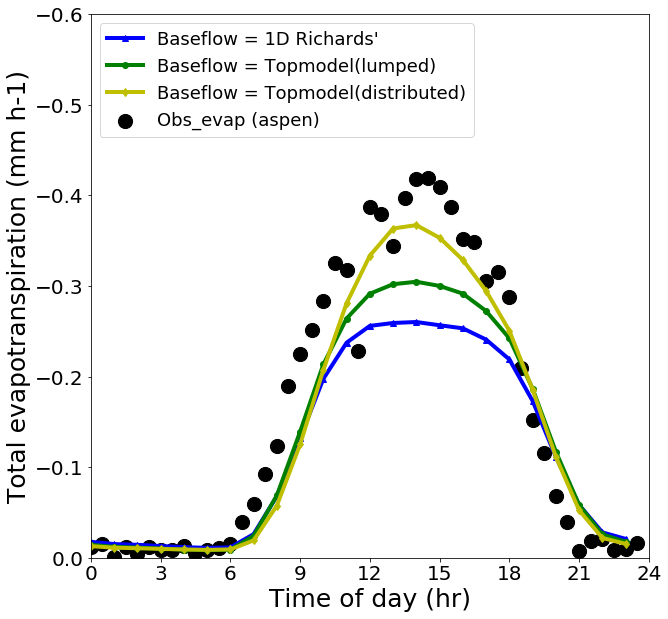

In [129]:
# create plot with the Parameterization of model representation of the lateral flux of liquid water
ET_Combine_Graph = ET_Combine.plot(legend=False,figsize=(10,10))
# invert y axis
ET_Combine_Graph.invert_yaxis()

ET_Combine_Graph.plot(ET_Combine["Baseflow = 1D Richards'"],color='b', marker='^',linewidth=4.0) 
ET_Combine_Graph.plot(ET_Combine['Baseflow = Topmodel(lumped)'], color='g', marker='o',linewidth=4.0)
ET_Combine_Graph.plot(ET_Combine['Baseflow = Topmodel(distributed)'], color='y', marker='d',linewidth=4.0)

ET_Combine_Graph.tick_params(labelsize = 25)
# plot scatter with x='xvals', y='Observation (aspen)'
ET_Combine_Graph.scatter(xvals, df_gp_hr['Obs_evap (aspen)'], color='black', s=200)
# add x, y label
ET_Combine_Graph.set_xlabel("Time of day (hr)", fontsize=25)
ET_Combine_Graph.set_ylabel("Total evapotranspiration (mm h-1)", fontsize=25)

handles, labels = ET_Combine_Graph.get_legend_handles_labels()
# show up the legend
ET_Combine_Graph.legend(handles[3:7], labels[3:7], loc=2,fontsize=18)
jtplot.figsize(x=10, y=10)
plt.xlim(0,24)
plt.ylim(0,-0.6)
x = [0,3,6,9,12,15,18,21,24]
plt.xticks(x, fontsize=20)
plt.yticks(fontsize=20)

#### 4.6) Validation between the observation and simulation data.

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from pysumma.Validation import validation

In [62]:
# defind simulation data
richard_simulation = ET_Combine ["Baseflow = 1D Richards'"]
lumped_simulation = ET_Combine ['Baseflow = Topmodel(lumped)']
distributed_simulation = ET_Combine ['Baseflow = Topmodel(distributed)']

In [63]:
# defind observation data
obs = df_gp_hr.groupby('level_0').mean()
observation_data = obs['Observation (aspen)']

In [64]:
# analyze validtation between BallBerry simulation and observation data.
validation.analysis(observation_data, richard_simulation)

Mean Absolute Error: 0.045292
Mean Squared Error: 0.004670
Root Mean Squared Error: 0.068335


In [65]:
# analyze validtation between BallBerry simulation and observation data.
validation.analysis(observation_data, lumped_simulation)

Mean Absolute Error: 0.030967
Mean Squared Error: 0.002121
Root Mean Squared Error: 0.046052


In [66]:
# analyze validtation between BallBerry simulation and observation data.
validation.analysis(observation_data, distributed_simulation)

Mean Absolute Error: 0.021956
Mean Squared Error: 0.000910
Root Mean Squared Error: 0.030168


## 5. Discussion

As stated in Clark et al., 2015, the following insights can be gained from this analysis:

* The simulation in Figure 8 illustrates the model representation of the lateral flux of liquid water, which determines (in part) the availability of soil water.

* The results in Figure 8 demonstrate strong sensitivities the lateral flow parameterization. The parameterizations based on power-law transmissivity profiles (both lumped and distributed) have more drainage of soil water at deeper soil layers; however, the distributed simulations include inflow from upslope, resulting in more plant-available soil water and an increase in transpiration. Taken together, the results in Figure 8 illustrate the strong interdependencies among different modeling decisions, which of course complicate discriminating among competing process parameterizations.

## 6. Post a new notebook and simulation results back to Hydroshare

In [66]:
from pysumma.hydroshare import hydroshare
hs = hydroshare.hydroshare()

Successfully established a connection with HydroShare


In [67]:
# zip a renewal SUMMA Model Instance to upload on HydroShare
import shutil, os
archive_name = os.path.expanduser(os.path.join('~', os.getcwd() +'/' + instance +'_new'))
root_dir = os.path.expanduser(os.path.join('~', os.getcwd() +'/' + instance))
shutil.make_archive(archive_name, 'zip', root_dir)
Model_instance = os.getcwd() +'/' + instance +'_new.zip'

In [68]:
# set meta data such as abstract, title, keywords, rtype to create a new SUMMA Model Instance
title = 'the Impact of Lateral Flow Parameterizations on ET of SUMMA Model at Reynolds Mountain East_new'
abstract = 'the Impact of Lateral Flow Parameterizations on ET of SUMMA Model at Reynolds Mountain East(new)'
keywords = ('SUMMA', 'Hydrologic Model', 'Reynolds Mountain East', 'Lateral Flow', 'Evapotranspiration')
rtype = 'ModelInstanceResource'
fpath = Model_instance,
metadata = '[{"creator":{"name":"Youngdon Choi"}}, {"creator":{"name":"Jeffrey Sadler"}}]'
extra_metadata = '{"key-1": "value-1", "key-2": "value-2"}'

In [69]:
# create a new SUMMA Model Instance on HydroShare
resource_id = hs.createHydroShareResource(title=title, content_files=fpath, keywords=keywords, abstract=abstract, resource_type='modelinstanceresource', public=False)

Resource Created Successfully                           


In [70]:
# set meta data such as abstract, title, keywords, rtype to create a SUMMA Composite Resource that contains SUMMA Model instance, output, and notebook.
title = 'the Impact of Lateral Flow Parameterizations on ET of SUMMA Model at Reynolds Mountain East_new'
abstract = 'the Impact of Lateral Flow Parameterizations on ET of SUMMA Model at Reynolds Mountain East(new)'
keywords = ('SUMMA', 'Hydrologic Model', 'Reynolds Mountain East', 'Lateral Flow', 'Evapotranspiration')
rtype = 'CompositeResource'
files = output_R, output_LT, output_DT
metadata = '[{"creator":{"name":"Youngdon Choi"}}, {"creator":{"name":"Jeffrey Sadler"}}]'
extra_metadata = '{"key-1": "value-1", "key-2": "value-2"}'

In [71]:
# create a new SUMMA Composite Resource on HydroShare
resource_id2 = hs.createHydroShareResource(title=title, content_files=files, keywords=keywords, abstract=abstract, resource_type='compositeresource', public=False)

Resource Created Successfully                           
Successfully Added Content Files                      


In [72]:
# add a new SUMMA Model Instance to a new SUMMA Composite Resource.
hs.addContentToExistingResource(resource_id2, [Model_instance])

Successfully Added Content Files                      


#### Save this notebook file to add the notebook to rhe resource of summa output

In [73]:
# add a new notebook to a new SUMMA Composite Resource.
npath = os.getcwd() +'/SummaModel_Reynolds_Evapotranspiration.ipynb'
# check the resource id on HS that created.
hs.addContentToExistingResource(resource_id2, [npath])

Successfully Added Content Files                      
